# **Tornado Analysis Notebook**

### Liam Shanahan

In this notebook I document the process of exploring the data and developing a solution for this tornado project. I am using an existing csv dataset, `tornado_data.csv`. The objective is to develop a class that will clean data and provide analysis into tornadic activity within specific areas and timeframes for both this data and additional data of this structure.

# Initial thoughts:

This looks like the kind of task that could be done in Pandas. When thinking about scalability, other tools like PySpark could be better. However, this looks like a small dataset and simple task, so it would probably be more straightforward to tackle it using Pandas.

# Exploratory Data Analysis

## Initial data inspection (without making changes)

I saw that the `'tornado.csv'` data file wasn't too large so the first thing I did was open it up in a Google docs spreadsheet to take a look at the data. Straight away I noticed some abnormalities:

- In the `fujita_scale` column, there were 'EFN' and 'FN' values as well as numbers ('N')

- Some events were in the alternative longitude format (lon >180)

Loading the data with Pandas to get some more concrete statistics:

In [2]:
import pandas as pd

df = pd.read_csv('tornado_data.csv')
df.head(10)

,Unnamed: 0,event_id,lat,lon,fujita_scale,datetime,grid_id
0,0,862096,35.05,-89.98,1,2019-10-21 05:00:00,1
1,1,10348864,35.07,-89.83,3,1994-11-27 15:00:00,1
2,2,10349256,35.07,-89.42,0,1994-06-26 20:00:00,2
3,3,5685492,35.02,-89.18,1,1999-01-17 18:00:00,3
4,4,5685485,35.07,-88.97,1,1999-01-17 19:00:00,4
5,5,5684232,35.05,-88.82,0,1999-01-22 12:00:00,4
6,6,5595090,35.07,-88.63,2,1997-03-01 05:00:00,5
7,7,5356287,35.03,-88.57,0,2003-05-05 08:00:00,5
8,8,83190,35.07,-88.61,1,2008-02-05 19:00:00,5
9,9,10118694,35.05,-88.72,3,1991-03-22 16:00:00,5


The un-named column appears to be just a unique index. If that's the case, I can make it the index in Pandas rather than creating a new index column. Checking:

In [3]:
uniq_vals = df['Unnamed: 0'].nunique()
row_count = df.shape[0]

print(f"The first (unnamed) column has {uniq_vals} unique values")
print(f"The dataframe has {row_count} rows")

The first (unnamed) column has 3048 unique values
The dataframe has 3048 rows


In [4]:
df.set_index('Unnamed: 0', inplace=True)
df.index.name = None
df.head(5)

,event_id,lat,lon,fujita_scale,datetime,grid_id
0,862096,35.05,-89.98,1,2019-10-21 05:00:00,1
1,10348864,35.07,-89.83,3,1994-11-27 15:00:00,1
2,10349256,35.07,-89.42,0,1994-06-26 20:00:00,2
3,5685492,35.02,-89.18,1,1999-01-17 18:00:00,3
4,5685485,35.07,-88.97,1,1999-01-17 19:00:00,4


When loading the dataframe again I can just do `df = pd.read_csv('tornado_data.csv', index_col=0)`



Now taking a look at some summary statistics of the rows:

In [5]:
print(df.describe())

           event_id          lat          lon      grid_id
count  3.048000e+03  3048.000000  3048.000000  3048.000000
mean   2.851732e+06    37.443642   -87.305692   150.210630
std    2.943513e+06     1.418255    11.347699    82.752213
min    1.008500e+04    35.010000   -90.000000     1.000000
25%    4.219588e+05    36.250000   -88.942500    80.000000
50%    8.861525e+05    37.250000   -87.670000   139.000000
75%    5.481238e+06    38.600000   -86.400000   220.000000
max    1.034992e+07    40.000000   272.700000   310.000000


Again we can see the maximum value for `lon` isn't within the conventional range (so must not be using the alternative longitude format). This can be changed later, but first I want to look a bit more at the characteristics of the dataset before making any changes. Most of the `lat` values appear to be within an appropriate range (where `-90<lat<90`). Fujita scale and datetime aren't showing up here so they must be non-numeric datatypes. Taking a look at the datatypes and some other summary statistics now:

In [6]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3048 entries, 0 to 3047
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   event_id      3048 non-null   int64  
 1   lat           3048 non-null   float64
 2   lon           3048 non-null   float64
 3   fujita_scale  3048 non-null   object 
 4   datetime      3048 non-null   object 
 5   grid_id       3048 non-null   int64  
dtypes: float64(2), int64(2), object(2)
memory usage: 166.7+ KB
None


These datatypes can be compared with the expected datatypes given in the task description/schema.

`fujita_scale` is an object, whilst the description lists it as an integer. This is probably because it contains 'EF' and 'F' values as mentioned before, which are likely strings. These will have to be converted into integer values.

Datetime should also be a datetime datatype, so that's also something that will have to be looked into. Everything else is in the right format.

It appears there are no NaN/null values in the dataset. Just double checking that:

In [7]:
print(df.isnull().sum())

event_id        0
lat             0
lon             0
fujita_scale    0
datetime        0
grid_id         0
dtype: int64


The task description also mentions duplicate event_ids. Duplicate values will need a look at to understand what's going on there.

Summarising initial findings:

- Datetime should be datetime object
- Fujita scale should be integer, EF and F values should be converted into their integer equivalents
- Longitude has values in the alternative format which will need to be converted to the conventional format

Now I'll look into further detail into these.

## Fujita Scale

As mentioned, I can see some EF and F values in the table. I'll print out the value counts of `fujita_scale` to get a better understanding:

In [8]:
print(df['fujita_scale'].value_counts())

0      1194
1      1127
2       499
3       166
4        52
F0        2
EF2       2
F1        2
5         2
EF3       1
F3        1
Name: fujita_scale, dtype: int64


It's only EF and F, there aren't any other abnormalities. I'll replace these before doing any further analysis. Will convert everything into a string, replace 'EF' and 'F' in those strings with just '', and convert back to a numeric datatype (which should jsut be an integer):

In [9]:
df['fujita_scale'] = df['fujita_scale'].astype(str)
df['fujita_scale'] = df['fujita_scale'].str.replace(r'(EF|F)', '',regex=True)
df['fujita_scale'] = pd.to_numeric(df['fujita_scale'], errors='coerce')

Now can look at the updated value counts to check the conversion went smoothly:

In [10]:
print(df['fujita_scale'].value_counts())

0    1196
1    1129
2     501
3     168
4      52
5       2
Name: fujita_scale, dtype: int64


Comparing with the original counts, I can do the maths myself and each value adds up to the combined total from before. Looking at datatypes and NaNs to check even further:

In [11]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3048 entries, 0 to 3047
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   event_id      3048 non-null   int64  
 1   lat           3048 non-null   float64
 2   lon           3048 non-null   float64
 3   fujita_scale  3048 non-null   int64  
 4   datetime      3048 non-null   object 
 5   grid_id       3048 non-null   int64  
dtypes: float64(2), int64(3), object(1)
memory usage: 166.7+ KB
None


It hasn't produced any NaNs despite using `errors=coerce`. Fujita scale is also an integer as expected. The conversion must be sucessful.

## Latitude and Longitude

I already identified that not all points are within the desired `-180<lon<180` range. Making a scatter plot of the distribution of latitude and longitude to get a better understanding:

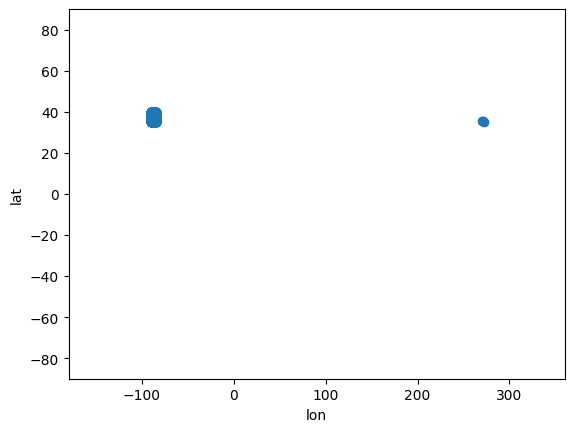

In [12]:
import matplotlib.pyplot as plt

plt.scatter(x=df['lon'], y=df['lat'])
plt.xlim(-180, 360)
plt.ylim(-90, 90)
plt.xlabel('lon')
plt.ylabel('lat')

plt.show()

It appears most are clustered in the correct location range, with the only exceptions having the alternative longitude format.

Incorrect longitude coordinates can be corrected using the formula in the task description. To do this efficiently, I can use an lambda function to set conditions and apply the formula to the dataframe for applicable rows:

In [13]:
df['lon'] = df['lon'].apply(lambda x: x-360 if x > 180 else x)

Plotting coordinates again to get a closer look at the distribution:

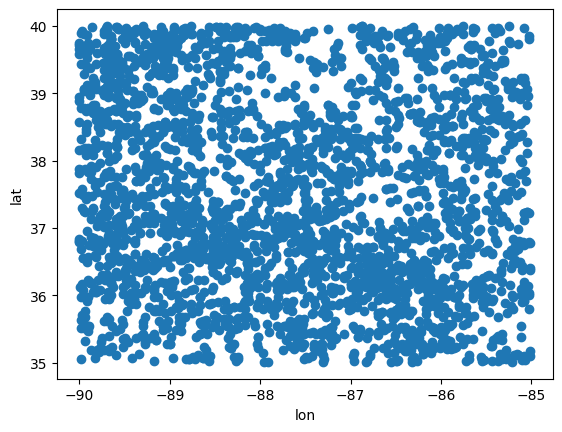

In [14]:
plt.scatter(x=df['lon'], y=df['lat'])
plt.xlabel('lon')
plt.ylabel('lat')
plt.show()

It appears to be distributed in a natural way with no strange anomalies or clusters. I looked at the location where the data is clustered (`-90<lat<-85`, `35<lon<40`) on a map. It corresponds to a region in the mid-west USA (where we are expecting the data to be from). There shouldn't be any glaring problems that need correcting here then.

I'll plot the same thing again, but this time include a gradient colourmap for all the different `grid_id`s. If there's an event where the `grid_id` corresponds to a location that's miles away from everything else with that `grid_id`, then there's probably an issue there. I'll just use some random colourmap:

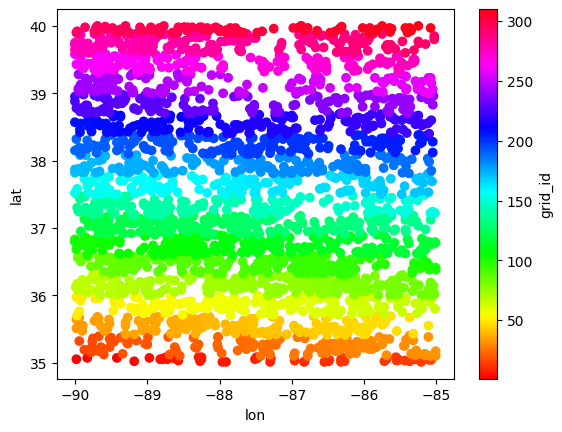

In [15]:
import numpy as np

plt.figure()

clmap = plt.cm.hsv
sc = plt.scatter(x=df['lon'], y=df['lat'], c=df['grid_id'], cmap=clmap)
plt.xlabel('lon')
plt.ylabel('lat')

cbar = plt.colorbar(sc)
cbar.set_label('grid_id')

plt.show()

There don't seem to be any events in wildly different locations from others with the same `grid_id`s. Just to confirm that, I'll find the maximum and minimum distances between events with the same `grid_id`. I can do this by grouping the events by their `grid_id`s, and then finding the maximum distance between values in those groups (using a lambda function again):

In [16]:
max_diffs = df.groupby('grid_id').agg({'lat': lambda x: x.max() - x.min(),'lon': lambda x: x.max() - x.min()})

max_diffs.sort_values('lat', ascending=False).head(8)

,lat,lon
grid_id,,
109,0.30,0.27
24,0.30,0.29
75,0.30,0.29
105,0.30,0.29
107,0.30,0.26
31,0.29,0.17
79,0.29,0.27
80,0.29,0.30


In [17]:
max_diffs.sort_values('lon', ascending=False).head(8)

,lat,lon
grid_id,,
264,0.22,0.30
63,0.26,0.30
70,0.26,0.30
80,0.29,0.30
127,0.26,0.30
88,0.24,0.29
199,0.25,0.29
132,0.24,0.29


It appears that the maximum distance is 0.30 degrees in both latitude and longitude. This seems like a reasonable grid size, so there shouldn't be any problems.

## Datetime

Before exploring the datetime column, it should be converted into a datetime object (as specified in the task description/schema):

In [18]:
df['datetime'] = pd.to_datetime(df['datetime'], errors='coerce')

Checking that all rows converted correctly:

In [19]:
df['datetime'].isna().sum()

0

In [20]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3048 entries, 0 to 3047
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   event_id      3048 non-null   int64         
 1   lat           3048 non-null   float64       
 2   lon           3048 non-null   float64       
 3   fujita_scale  3048 non-null   int64         
 4   datetime      3048 non-null   datetime64[ns]
 5   grid_id       3048 non-null   int64         
dtypes: datetime64[ns](1), float64(2), int64(3)
memory usage: 166.7 KB
None


There are no NaT/null values despite using `errors='coerce'`, and the column now shows as a datetime datatype, so no problems there. Just visualising to double check they look right:

In [21]:
df.head(5)

,event_id,lat,lon,fujita_scale,datetime,grid_id
0,862096,35.05,-89.98,1,2019-10-21 05:00:00,1
1,10348864,35.07,-89.83,3,1994-11-27 15:00:00,1
2,10349256,35.07,-89.42,0,1994-06-26 20:00:00,2
3,5685492,35.02,-89.18,1,1999-01-17 18:00:00,3
4,5685485,35.07,-88.97,1,1999-01-17 19:00:00,4


Now I can check that events are within the expected datetime range (`1991-01-01 <= datetime <= 2022-12-31`) by returning the max and min datetimes:

In [22]:
earliest_datetime = df['datetime'].min()
latest_datetime = df['datetime'].max()

print(f"The earliest datetime is: {earliest_datetime}")
print(f"The latest datetime is: {latest_datetime}")

The earliest datetime is: 1991-02-13 16:00:00
The latest datetime is: 2021-12-11 07:00:00


Both appear to be within the acceptable range. If new data is ever added, we might also want to apply the following to deal with NaT values and check everything is within the expected range:

In [23]:
df = df.dropna(subset=['datetime'])

start_date = '1991-01-01'
end_date = '2022-12-31'

df = df[(df['datetime'] >= start_date) & (df['datetime'] <= end_date)]

However, for the purposes of this exercise, this isn't necessary since all the data is in the correct range and format.

In the task description it says that we should have an hourly resolution for the datetime data. Just checking if that matches the data:

In [24]:
resolution = df['datetime'].dt.minute.eq(0) & df['datetime'].dt.second.eq(0)
if resolution.all():
    print("Hourly resolution")
else:
    print("Not hourly resolution")

Hourly resolution


This is as expected. It appears there are no more abnormalities within the datetime column.

## Duplicates

**Duplicate event_ids**

In the task description it says `event_id`s may have duplicates, corresponding to a moving tornado. I'm not entirely sure what that means, so I'll take a closer look. First by making a new dataframe with duplicate `event_id`s:

In [25]:
df2 = df[df.duplicated(subset='event_id', keep=False)]
df2 = df2.sort_values(by=['event_id'])
df2.head(20)

,event_id,lat,lon,fujita_scale,datetime,grid_id
785,21876,36.01,-85.21,0,2007-04-26 14:00:00,82
795,21876,36.08,-85.10,0,2007-04-26 15:00:00,83
2702,25901,39.37,-87.98,0,2007-05-25 13:00:00,267
2703,25901,39.38,-87.95,0,2007-05-25 14:00:00,267
1753,59846,37.72,-87.18,2,2007-10-18 19:00:00,163
1740,59846,37.67,-87.37,2,2007-10-18 18:00:00,162
1582,59854,37.20,-87.48,1,2007-10-18 18:00:00,144
1583,59854,37.22,-87.45,1,2007-10-18 19:00:00,144
1126,59855,36.84,-87.90,1,2007-10-18 19:00:00,108
1125,59855,36.84,-87.95,1,2007-10-18 18:00:00,108


Initially I thought there might only be tornadoes with the same `event_id` but different `grid_id` to represent tornadoes moving into different grids, however it seems there are duplicates that have the same `event_id` and `grid_id` but different datetime. This must mean tornadoes moving within the same grid are also included in the data. Taking a look at tornadoes with duplicate `event_id`s and `grid_id`s more closely:

In [26]:
df3 = df[df.duplicated(subset=['event_id','grid_id'], keep=False)]
df3 = df3.sort_values(by=['event_id'])

df3.head(20)

,event_id,lat,lon,fujita_scale,datetime,grid_id
2703,25901,39.38,-87.95,0,2007-05-25 14:00:00,267
2702,25901,39.37,-87.98,0,2007-05-25 13:00:00,267
1583,59854,37.22,-87.45,1,2007-10-18 19:00:00,144
1582,59854,37.20,-87.48,1,2007-10-18 18:00:00,144
1126,59855,36.84,-87.90,1,2007-10-18 19:00:00,108
1125,59855,36.84,-87.95,1,2007-10-18 18:00:00,108
374,76269,35.94,-89.40,1,2008-01-08 15:00:00,51
373,76269,35.91,-89.46,1,2008-01-08 14:00:00,51
1143,76640,36.85,-87.80,1,2008-02-05 19:00:00,109
1142,76640,36.81,-87.88,1,2008-02-05 18:00:00,109


It seems like most rows for duplicate events within the same grid have `datetime` values differing by 1 hour from each other. This must be because the tornadoes are recorded every hour - if they're within the same grid then they're still recorded every hour.

Because the duplicates are meant to represent moving tornadoes, any duplicates with the same event_id and datetime likely aren't meant to be there. Checking if there are any (since they will have to be removed from the data if so):

In [27]:
df4 = df[df.duplicated(subset=['event_id','datetime'], keep=False)]

df4.head()

,event_id,lat,lon,fujita_scale,datetime,grid_id


**Moving Tornado Track Distance**

It's likely that tornadoes which move across an unusually large distance (`lat` and `lon`) are due to some problems with the data and these might have to be removed.

To check for these, I should calculate the maximum distance (using `lat` and `lon`) between rows with duplicate `event_id`s. I'll want to find it in km or miles so that I can compare it with the reasonable range of actual tornado track lengths.

I had to look online to find a way to do this with coordinates, since you have to take the curvature of the earth into account. It's possible using this haversine function below:

In [28]:
import numpy as np

def haversine(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))
    r = 6371

    return c * r

Since the radius of the earth (`r`) was given in km above, the final unit of distance will also be km.

I'll want to group the `event_id`s together in the dataframe and then apply the above function to all the rows `lat` and `lon` coordinates and find the maximum distance. This isn't a very time-efficient way of doing it, but it'll do for this EDA:

In [29]:
def max_distance(group):
    if len(group) < 2:
        return 0
    return max(haversine(row1.lon, row1.lat, row2.lon, row2.lat) for idx1, row1 in group.iterrows() for idx2, row2 in group.iterrows() if idx1 < idx2)

Now applying to the original dataframe to give the maximum distances

In [30]:
max_d = df.groupby('event_id').apply(max_distance)

max_d = max_d.sort_values(ascending=False)
max_d.head(10)

event_id
5293473    47.961566
883007     42.195741
997421     41.569290
5501329    40.850967
607146     40.686665
5358411    40.602973
5641117    39.857853
5495817    38.722787
5154642    37.796881
280344     37.552514
dtype: float64

48km for the same tornado doesn't look too unreasonable. I looked it up online and it appears the average tornado is about 2-5km, but the longest ever recorded was over 200km. There shouldn't be any problems with the data here then.

**Checking for Other Duplicates**

Now checking for duplicates in datetime:

In [31]:
df6 = df[df.duplicated(subset='datetime', keep=False)]
df6 = df6.sort_values(by='datetime')

row_count = df6.shape[0]
print(f"The df has {row_count} rows")

df6.head(10)

The df has 2277 rows


,event_id,lat,lon,fujita_scale,datetime,grid_id
1483,10073207,37.20,-89.75,1,1991-02-13 16:00:00,136
1260,10073208,37.18,-89.70,1,1991-02-13 16:00:00,119
624,10118696,36.23,-88.08,2,1991-03-22 17:00:00,73
88,10118697,35.22,-88.32,1,1991-03-22 17:00:00,21
1179,10030615,36.65,-87.18,2,1991-03-22 17:00:00,111
93,10118698,35.38,-88.02,1,1991-03-22 17:00:00,22
1180,10030616,36.73,-87.03,2,1991-03-22 18:00:00,111
281,10118701,35.48,-87.63,2,1991-03-22 18:00:00,40
1425,10030617,36.93,-86.62,2,1991-03-22 18:00:00,130
1178,10030634,36.65,-87.02,2,1991-04-09 12:00:00,111


Ok, there are a lot of values with duplicate datetimes. Previously, I found that no events had the same event_id and same datetime, so most of these probably aren't the same event. If we have any rows with the same datetime and same coordinates, that's likely to be an error (since it can't exist in reality). Checking for that:

In [32]:
df8 = df[df.duplicated(subset=['lat','lon'], keep=False)]

df8.head()

,event_id,lat,lon,fujita_scale,datetime,grid_id
6,5595090,35.07,-88.63,2,1997-03-01 05:00:00,5
13,5245175,35.07,-88.63,1,2001-05-31 14:00:00,5
42,372675,35.05,-85.54,1,2012-03-02 11:00:00,13
43,372686,35.05,-85.54,1,2012-03-02 17:00:00,13
75,10349621,35.33,-89.15,2,1994-06-26 18:00:00,18


Hmmm... two tornadoes on 2012-03-02 have the exact same coordinates, but a different datetime and different event_id. I assume this means two tornadoes hit the exact same spot on the same day. Unlinkely, but I don't think it's an impurity in the data.

I'm going to assume that the reason so many tornadoes in the dataset have the same datetime is because they arrive with storms and come in batches. Plotting the frequency with time to get a better idea of that:

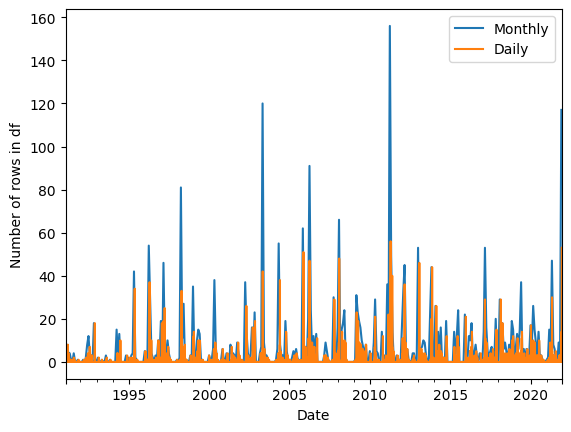

In [33]:
df7 = df.copy()

df7.set_index('datetime', inplace=True)
freq1 = df7.resample('M').size()
freq2 = df7.resample('D').size()

plt.figure()
freq1.plot(label='Monthly')
freq2.plot(label='Daily')

plt.xlabel('Date')
plt.ylabel('Number of rows in df')
plt.legend()

plt.show()

They do appear to come in spikes. This plot also shows that they're resonably distributed in time, without an unusual amount on any particular day. There don't appear to be any obvious anomalies here then.

To summarise, there don't appear to be any duplicate data points or any further anomalies. The only data cleansing necessary will be the simple changes made to `fujita_scale`, `datetime` and `lon`.

# Data Cleaning

**Summary of Necessary Steps**

Fromt the EDA above, I've concluded that for this particular dataset and the context of this exercise, there are only a few small steps that need to be applied to read and cleanse the data. Those are:

- Read into Pandas dataframe with first column as index column: `df = pd.read_csv('tornado_data.csv', index_col=0)`
- Convert `datetime` column to a datetime object
- Convert `lon` coordinates from alternative format to conventional format
- Convert all EF and F in `fujita_scale` to number and integer datatype


I've already written the code for these transformations above, and already checked that the code is working effectively. Putting it all together into one self-contained cell (I can later copy this to a .py file):

In [34]:
import pandas as pd

#loading data to pandas dataframe with first column as index column
df = pd.read_csv('tornado_data.csv', index_col=0)

#convert datetime column to datetime datatype
df['datetime'] = pd.to_datetime(df['datetime'], errors='coerce')

#convert alternative longitudes to conventional format
df['lon'] = df['lon'].apply(lambda x: x-360 if x > 180 else x)

#converting EF and F fujita scale rows to numerical values and the whole column to integer datatype
df['fujita_scale'] = df['fujita_scale'].astype(str)
df['fujita_scale'] = df['fujita_scale'].str.replace(r'(EF|F)', '', regex=True)
df['fujita_scale'] = pd.to_numeric(df['fujita_scale'], errors='coerce')

I can again check that everything is working as expected with this combined code:

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3048 entries, 0 to 3047
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   event_id      3048 non-null   int64         
 1   lat           3048 non-null   float64       
 2   lon           3048 non-null   float64       
 3   fujita_scale  3048 non-null   int64         
 4   datetime      3048 non-null   datetime64[ns]
 5   grid_id       3048 non-null   int64         
dtypes: datetime64[ns](1), float64(2), int64(3)
memory usage: 166.7 KB


All the datatypes are now correct with no NaNs/nulls. Looking at the summary statistics:

In [36]:
df.describe()

,event_id,lat,lon,fujita_scale,grid_id
count,3.048000e+03,3048.000000,3048.000000,3048.000000,3048.000000
mean,2.851732e+06,37.443642,-87.660023,0.936024,150.210630
std,2.943513e+06,1.418255,1.440385,0.968239,82.752213
min,1.008500e+04,35.010000,-90.000000,0.000000,1.000000
25%,4.219588e+05,36.250000,-88.950000,0.000000,80.000000
50%,8.861525e+05,37.250000,-87.670000,1.000000,139.000000
75%,5.481238e+06,38.600000,-86.410000,1.000000,220.000000
max,1.034992e+07,40.000000,-85.010000,5.000000,310.000000


The `lon` column is corrected and all other columns appear to be as expected.

# Building Class for Extracting Information from Data

**Ensuring Clean Data**

For this task, I will want to ensure that the data is cleansed before applying any of the other methods to each instance. I'll make a `cleanse_data` method as specified in the task description. In the `__init__` for the class, I'll load in the data and apply the `cleanse_data` method to ensure the data is clean.

It's worth considering also applying the `cleanse_data` method within each of the other methods specified in the task description, to overcome issues where the data might have been made 'dirty' between method calls. For the purposes of this assignment, however, it's probably not necessary.

**Time Ranges**

I'm unsure from the task description whether all the new methods that calculate characteristics of the dataset will be calculated only for a specific time range (given `start_date` and `end_date`). It's only explicitly stated for the 'worst historical tornadoes' method, however it might be useful for the other methods.

I'll do a date range for all of them since there's little harm in that. This means it would be useful to define another method for getting a specific date range, which I can then call in the other methods to reduce the amount of code required. I'll make it first as a simple function below, for testing:

In [37]:
def date_filter(df, start_date, end_date):

    df = df[(df['datetime'] >= start_date) & (df['datetime'] <= end_date)]

    return df

## 'Worst tornadoes'

**Understanding Task**

My understanding of the 'worst tornadoes' task is that for an input date range, the method will return a dataframe which contains all the tornadoes with the highest fujita scale rating observed during that timeframe. For example, if the highest fujita scale tornado recorded within a certain month was 3, the method would return all the tornadoes which had a fujita scale of 3 during that month.

There are a few things I'm not sure of:

- Should the method return all rows from the dataframe that have the highest fujita scale, or all the individual tornadoes/events (eg. if the same tornado has multiple rows with duplicate `event_id`s, but different datetimes or locations, should this 'worst tornadoes' dataframe show that as only one row)?

Since the question mentions the tracking of individual `datetime` and `grid_id` values, I will return all the rows representing the same tornado, as long as they are when it is at its peak Fujita rating (the same tornado can have different ratings at different datetimes). This means there will be multiple rows with the same `event_id`, `fujita_rating` and even `grid_id`.

- In what order should tornadoes appear in the 'worst tornadoes' dataframe?

Since all the tornadoes will have the same fujita ranking, they cannot be ordered by damage. Instead, I'll order them by how recently they occured, with the most recent tornadoes appearing at the top of the dataframe.

**Implementation**

Creating this would be quite simple. I'll have to do the following:

- Filter dataframe to only the dates within the input date range (I can use the function I defined previously, which will be a method in the final class)
- Find the maximum Fujita rating from the filtered dataframe
- Filter dataframe again to include only the rows with that `fujita rating`
- Sort the resulting dataframe by datetime

I'll start by writing it as a simple function. Once I've checked that it works I can make it a method in the final class:

In [38]:
def worst_tornadoes(df, start_date, end_date):

    df = date_filter(df, start_date, end_date)
    max_fuj = df['fujita_scale'].max()
    df = df[df['fujita_scale'] == max_fuj]
    df = df.sort_values(by='datetime', ascending=False)

    return df

Now testing over the entire date range. From the value count of the `fujita_scale` column I did earlier, the worst rated tornadoes in the entire dataframe should have a Fujita rating of 5, and there should be 2 rows with this rating:

In [39]:
worst_tornadoes(df, '1991-01-01','2022-12-31').head(20)

,event_id,lat,lon,fujita_scale,datetime,grid_id
306,5641117,35.43,-87.20,5,1998-04-16 17:00:00,42
104,5641117,35.25,-87.58,5,1998-04-16 16:00:00,24


It's giving the correct result. Now I'll try a smaller date range.

From inspecting the original dataframe, in April 1991, the worst rated tornado had a Fujita rating of 2, and there should be 3 rows with this value:

In [40]:
worst_tornadoes(df, '1991-04-01','1991-04-30').head(20)

,event_id,lat,lon,fujita_scale,datetime,grid_id
1178,10030634,36.65,-87.02,2,1991-04-09 12:00:00,111
1450,10030640,36.97,-85.87,2,1991-04-09 12:00:00,132
1177,10030632,36.65,-87.17,2,1991-04-09 11:00:00,111


It's working for this test case too. I can test again once it's integrated into the final class as a method.

## 'Number of tornadoes that move through multiple `grid_id`s'

**Understanding Task**

The task requires another method that gives the number of tornadoes that move through multiple `grid_id`s. This should be simple, however I'll have to think about the following:

- The question doesn't specify a particular time range over which this number should be calculated.

I'll assume start and end dates are also given as inputs, and that we want to find the number of tornadoes passing through multiple `grid_id`s within a specified range.

- Should I include rows with duplicate event_ids as separate tornadoes?

I won't. The question asks for the number of individual tornadoes, not indovidual rows. I'll therefore have to group together rows with duplicate `event_id`s. If a tornado passes through 3 different `grid_id`s, it'll still be counted as a single tornado.

**Implementation**

Given my understanding of the task, it should be fairly simple to implement:

- Group together rows with the same event_id (to get all individual tornadoes)
- For each group, find the number of unique `grid_ids` (it'll have to be unique because we only want the number of different grids it's moved through and some tornadoes move within the same grid, as noted during the EDA)
- Filter the resulting dataframe to give only the events which moved through more than one grid
- Find the final number of resulting tornadoes by counting the groups in the final filtered dataframe

Again I'll code it up as a simple function first and then add it to the final class after checking it works ok:

In [41]:
def multiple_grid_count(df, start_date, end_date):

    df = date_filter(df, start_date, end_date)
    grid_counts = df.groupby('event_id')['grid_id'].nunique()
    moving_ind = grid_counts[grid_counts > 1].index
    multiple_grid_count = len(moving_ind)

    return multiple_grid_count

I can now test this out. From eyeballing the dataframe, on 2015-12-23 there are 21 rows. However, there are only 20 tornadoes since one `event_id` appears 2 times in 2 separate `grid_id`s, representing the same tornado moving through them. Hence, for this time period out function should give an answer of 1 (1 tornado that moves through multiple grids). Now testing:

In [42]:
start_date = '2015-12-23'
end_date = '2015-12-24'

multiple_grid_count(df, start_date, end_date)

1

It appears to be working ok.

## 'Probability of a tornado occuring with at least severity F'

**Understanding Task**

I'll make a method that takes a certain cell (`grid_id`) and Fujita rating as an input, and returns the probability according to the formula:

$$
P(\text{tornado}_i) = \frac{\text{no. of tornadoes in cell } i \text{ with scale } \geq F}{\text{no. of days considered}}
$$

Similar to the last part, the question doesn't specify that a particular time range should also be given as input, however I'll do this anyway (if the user wants results for the entire dataframe, they can simply give the maximum date range).

When finding the number of tornadoes within a grid_id, I'll have to be careful of duplicates. Within a particular grid_id, it's possible that the same event will appear multiple times in the dataframe. We only want the unique tornadoes, so these will have to be grouped together.

It's also possible that the same tornado/event will move from one `grid_id` to another, and then change Fujita rating. We only want to consider the Fujita rating of such tornadoes within the specific `grid_id` which is given as input.

**Implementation**

To overcome the above, I will have to:

- Filter out events to include only those within the specified date range
- Filter out events to include only those with the specified input `grid_id`
- Filter out events to only include those above input Fujita threshold
- Find the number of unique `event_id`s from the resulting dataframe to give the number of unique tornado events with the desired `event_id` and `grid_id` (we've already filtered by fujita threshold so won't have to worry about tornadoes that move from one grid_id with one Fujita rating to another grid_id with a different Fujita rating)
- Divide this number by the number of days within the specified date range

As before, I can first code this as a function first for testing:

In [43]:
def grid_severity_probability(df, grid_id, fujita_scale, start_date, end_date):

    df = date_filter(df,start_date, end_date)
    df = df[df['grid_id'] == grid_id]
    df = df[df['fujita_scale'] >= fujita_scale]
    unique_event_count = df['event_id'].nunique()
    day_count = (pd.to_datetime(end_date) - pd.to_datetime(start_date)).days + 1  # +1 to include the end date

    probability = unique_event_count / day_count

    return probability

I can test this by calculating the probability of a Fujita scale 0 tornado for all the grid_ids across the entire timeframe, and checking that the results are within a reasonable range:

In [44]:
start_date = '1991-01-01'
end_date = '2022-12-31'

prob_test = [grid_severity_probability(df,i,0,start_date,end_date) for i in range(1,df['grid_id'].max()+1)]

In [45]:
print(max(prob_test))
print(min(prob_test))

0.0028234086242299797
8.555783709787816e-05


I can also calculate the actual probability for one of the grids to check that it's working. For `grid_id=1`, there are only 2 tornadoes of Fujita rating 0 or above between 1991-01-01 and 2022-12-31.

Number of days between 1991-01-01 and 2022-12-31 (first and last day inclusive) = 32*365 + 8 (leap years) = 11688.

P = 2/11688 = 0.00017111567

This should be the same as the result of the function, when giving the `fujita_scale` input as 0, the `grid_id` input as 1, and including the entire date range:

In [46]:
start_date = '1991-01-01'
end_date = '2022-12-31'

grid_severity_probability(df,1,0,start_date,end_date)

0.00017111567419575633

Great, the function appears to be working. Now I'll put it all into one big class.

## Combining into class

As I mentioned before I'll read and clean the data as part of the `__init__`. Putting all the things discussed above into one class and giving each method a docstring:

In [47]:
import pandas as pd

class tornado_class:
    def __init__(self, file_name):
        """
        Initialises tornado_class. Reads tornado data from csv file to Pandas dataframe and applies
        clean_data method each time a new instance of the class is made.

        Args:
            file_name (str): The path to the csv file containing tornado data.
        """
        self.df = pd.read_csv(file_name, index_col=0)
        self.clean_data()

    def clean_data(self):
        """
        Cleans the dataframe by converting datetime column to datetime datatype, converting any
        alternative longitude values to the conventional format and removing 'F' or 'EF' prefixes
        from the fujita_scale column.

        Modifies the dataframe in place.
        """
        self.df['datetime'] = pd.to_datetime(self.df['datetime'], errors='coerce')
        self.df['lon'] = self.df['lon'].apply(lambda x: x-360 if x > 180 else x)
        self.df['fujita_scale'] = self.df['fujita_scale'].astype(str)
        self.df['fujita_scale'] = self.df['fujita_scale'].str.replace(r'(EF|F)', '', regex=True)
        self.df['fujita_scale'] = pd.to_numeric(self.df['fujita_scale'], errors='coerce')

    def date_filter(self, start_date, end_date):
        """
        Filters the dataframe to give rows within a specified date range.

        Args:
            start_date (str): The start date of the desired date range, inclusive.
            end_date (str): The end date of the desired date range, inclusive.

        Returns:
            Pandas dataframe: A filtered dataframe within the specified date range.
        """
        start_date = pd.to_datetime(start_date)
        end_date = pd.to_datetime(end_date)
        df = self.df[(self.df['datetime'] >= start_date) & (self.df['datetime'] <= end_date)]
        return df

    def worst_tornadoes(self, start_date, end_date):
        """
        For a given date range, finds the tornado within that range with the highest Fujita scale
        rating and returns a dataframe containing all rows (including lon, lat, grid_id and datetime)
        with an equivalently high Fujita rating, sorted by date in descending order.

        Args:
            start_date (str): The start date of the desired date range, inclusive.
            end_date (str): The end date of the desired date range, inclusive.

        Returns:
            Pandas dataframe: A dataframe of the worst historical tornadoes within the input date
            range, sorted by date.
        """

        df = self.date_filter(start_date, end_date)
        max_fuj = df['fujita_scale'].max()
        df = df[df['fujita_scale'] == max_fuj]
        df = df.sort_values(by='datetime', ascending=False)
        return df

    def multiple_grid_count(self, start_date, end_date):
        """
        Counts the number of unique tornado events that have moved through multiple grids.

        Args:
            start_date (str): The start date of the desired date range, inclusive.
            end_date (str): The end date of the desired date range, inclusive.

        Returns:
            int: The number of unique tornadoes that have moved through more than one grid.
        """
        df = self.date_filter(start_date, end_date)
        grid_counts = df.groupby('event_id')['grid_id'].nunique()
        moving_ind = grid_counts[grid_counts > 1].index
        multiple_grid_count = len(moving_ind)
        return multiple_grid_count

    def grid_severity_probability(self, grid_id, fujita_scale, start_date, end_date):
        """
        Calculates the probability of a tornado occurring with at least a certain Fujita scale rating in
        a specified grid, given the formula in the task description.

        Args:
            grid_id (int): The grid_id to calculate the probability for.
            fujita_scale (int): The minimum Fujita rating to calculate the probability for.
            start_date (str): The start date of the desired date range, inclusive.
            end_date (str): The end date of the desired date range, inclusive.

        Returns:
            float: The probability of a tornado occurrence in the given grid_id with at least the given
            Fujita scale.
        """
        df = self.date_filter(start_date, end_date)
        df = df[df['grid_id'] == grid_id]
        df = df[df['fujita_scale'] >= fujita_scale]
        unique_event_count = df['event_id'].nunique()
        day_count = (pd.to_datetime(end_date) - pd.to_datetime(start_date)).days + 1 #(inclusive of last day)
        probability = unique_event_count / day_count
        return probability

Now testing it out, will first make an instance of the class. The `__init__` will load in the data and clean it:

In [48]:
tornado_object = tornado_class('tornado_data.csv')

First, I'll test out the worst tornadoes method using the example timeframe used in testing earlier and see if it gives the same result:

In [49]:
tornado_object.worst_tornadoes('1991-04-01','1991-04-30')

,event_id,lat,lon,fujita_scale,datetime,grid_id
1178,10030634,36.65,-87.02,2,1991-04-09 12:00:00,111
1450,10030640,36.97,-85.87,2,1991-04-09 12:00:00,132
1177,10030632,36.65,-87.17,2,1991-04-09 11:00:00,111


It gives the correct result. Now I'll try the same test as before again for the multiple grid count:

In [50]:
start_date = '2015-12-23'
end_date = '2015-12-24'

tornado_object.multiple_grid_count(start_date, end_date)

1

Correct again. Finally, I'll use the same test as before with the probability method:

In [51]:
start_date = '1991-01-01'
end_date = '2022-12-31'

tornado_object.grid_severity_probability(1,0,start_date,end_date)

0.00017111567419575633

All seems to be working fine.

# Notes

## Scalability

The task description states 'please consider how your solution would scale if we had many more days, additional weather/climate variables and grid ids'. My solution to task I and II is only applicable to this particular sample dataset. Hence I used Pandas and only did the data cleaning steps that were necessary. There are a few things to think about with additional data:

**Efficiency**

For processing significantly larger quantities of data, PySpark could be used instead of Pandas to distribute processing tasks. Data could also be stored and accessed via the cloud instead of locally.

I was considering using PySpark for this assignment, however due to the small quantity of data and simplicity of using Pandas, it was more convinient (PySpark was not necessary).

Perhaps I could look into using more efficient data structures and optimising the code to minimise time complexity too.

**Additional Data Cleaning and Checks**

For this task, I only applied the data cleaning necessary for the dataset provided. When considering unseen data there might be additional (QA) checks necessary such as:

- Removing any rows with NaN values
- Ensuring `-90<lat<90` and removing or correcting any outliers
- Removing rows outside the expected date range
- Removing rows with a track length (see EDA) greater than what is expected of a tornado
- Remove completely duplicate rows
- Remove rows with duplicate `event_id`s that have significantly different datetime values
- Removing rows which are not located in the expected area, in the United States.

## Modelling Risk with ML

Finally, the task description mentions 'please consider how you could model the risk of a tornado occurring in a given region, using statistical and/or machine learning methods'. There are many ways to think about this, but a few potential ideas are:

- Applying the `grid_severity_probability` method to the chosen location for all historical data at consistent time intervals would give a time-series dataset describing how the probability of a tornado in the chosen location varies over time. Various time-series modelling methods could then be applied, using this past data, to predict how the probability would change in the near future (this could be beneficial for predicting seasonal fluctuations).

- If we had 'additional weather/climate variables', these could be used to train supervised machine learning models to give a better prediction of the probability of a tornado occuring in a certain location and at a certain time than `grid_severity_probability`. The dataset could be separated into consistent time intervals. Supervised models could then be trained on the data with grid_id, time of year and weather/climate variables as inputs and number of tornadoes as outputs. Once trained, weather/climate vairables can be input for a certain grid_id and time of year, and the models would be able to predict the number of tornadoes that would occur during this time (or probability). This could be beneficial if the weather/climate variables in the near future are known, and you would like to predict the tornado probability at that time. A number of different supervised models could be attempted for such a task, including neural networks.